In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 7)

In [3]:
import seaborn as sns
from datetime import datetime, timedelta

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
from scipy import stats
import statsmodels.api as sm
from itertools import product

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# loading the dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('crypto-markets.csv', parse_dates=['date'], index_col='date',date_parser=dateparse)
df.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [8]:
# extracting the bitcoin data

btc = df[df['symbol']=='BTC']

# dropping some columns
btc.drop(['slug','symbol','name','ranknow','volume','market','close_ratio','spread'],axis=1,inplace=True)

In [9]:
print(len(btc))

1761


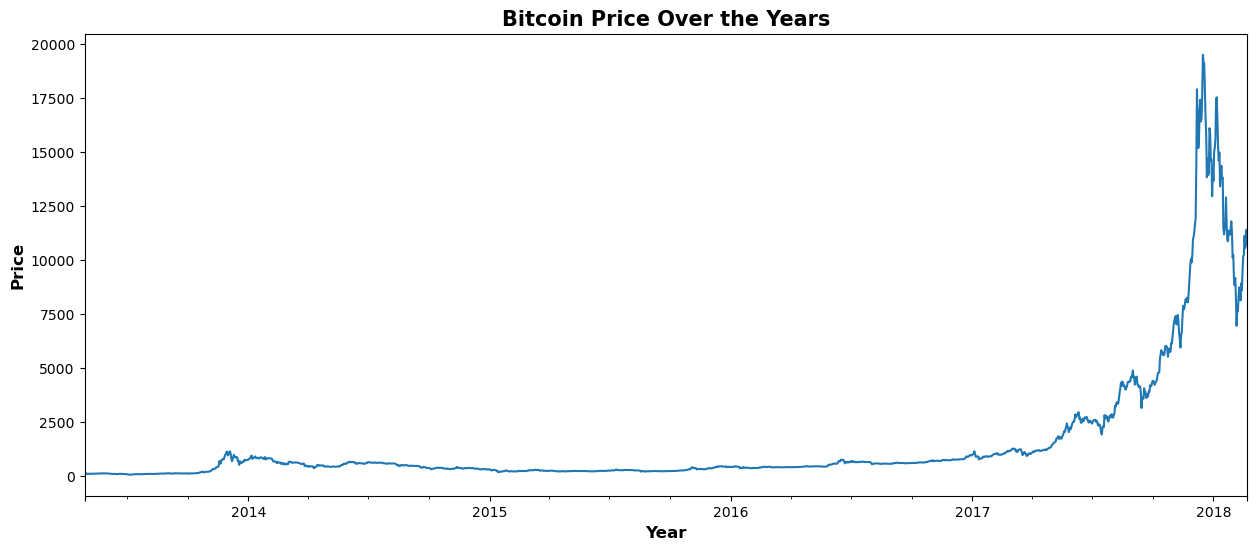

In [10]:
btc['close'].plot(figsize=(15, 6))
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.title('Bitcoin Price Over the Years', fontsize=15, fontweight='bold')
plt.show()

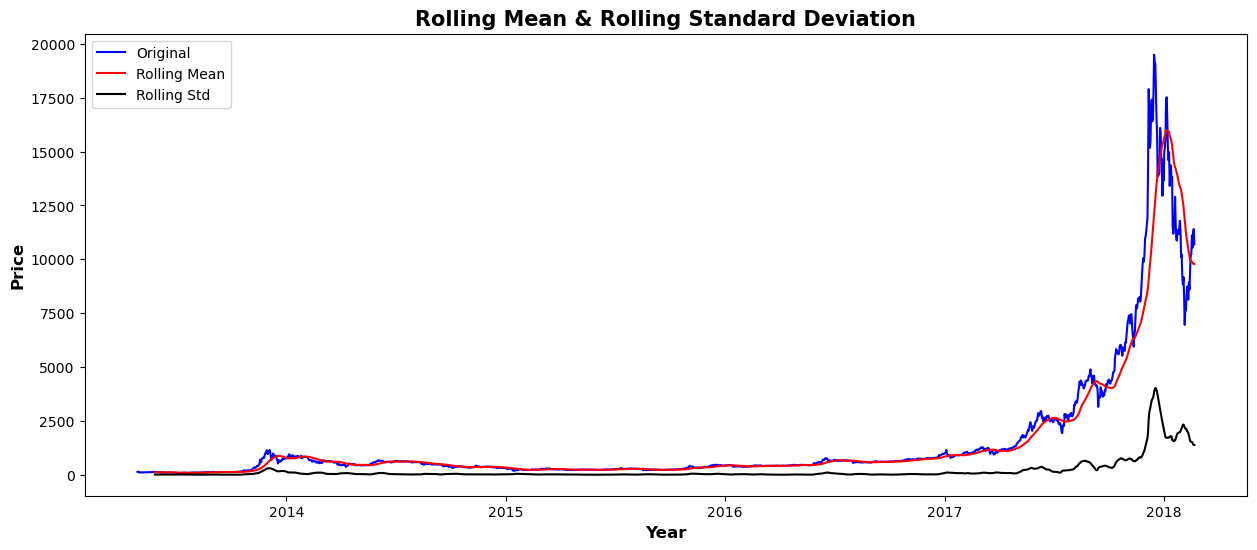

In [11]:
# plotting rolling average
window_size = 30
rolling_mean = btc['close'].rolling(window=window_size).mean()
rolling_std = btc['close'].rolling(window=window_size).std()

plt.figure(figsize=(15,6))
plt.plot(btc['close'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

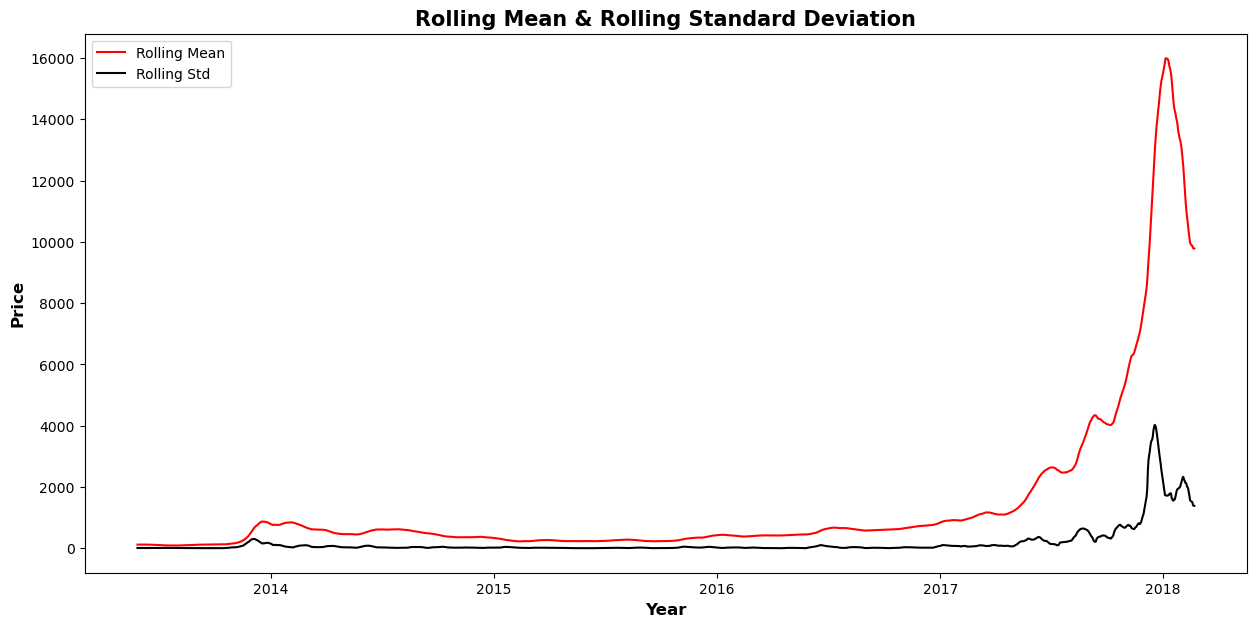

In [12]:
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

<Figure size 1500x600 with 0 Axes>

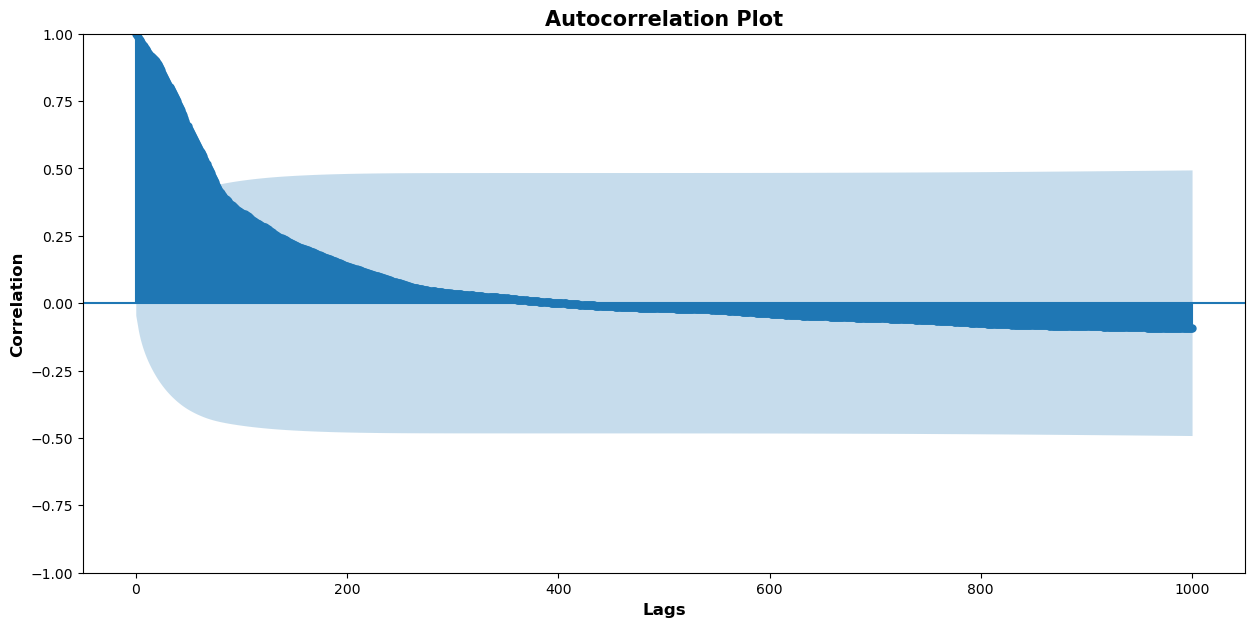

In [13]:
# plotting the autocorrelation plot
plt.figure(figsize=(15,6))
plot_acf(btc['close'], lags=1000)
plt.xlabel('Lags', fontsize=12, fontweight='bold')
plt.ylabel('Correlation', fontsize=12, fontweight='bold')
plt.title('Autocorrelation Plot', fontsize=15, fontweight='bold')
plt.show()

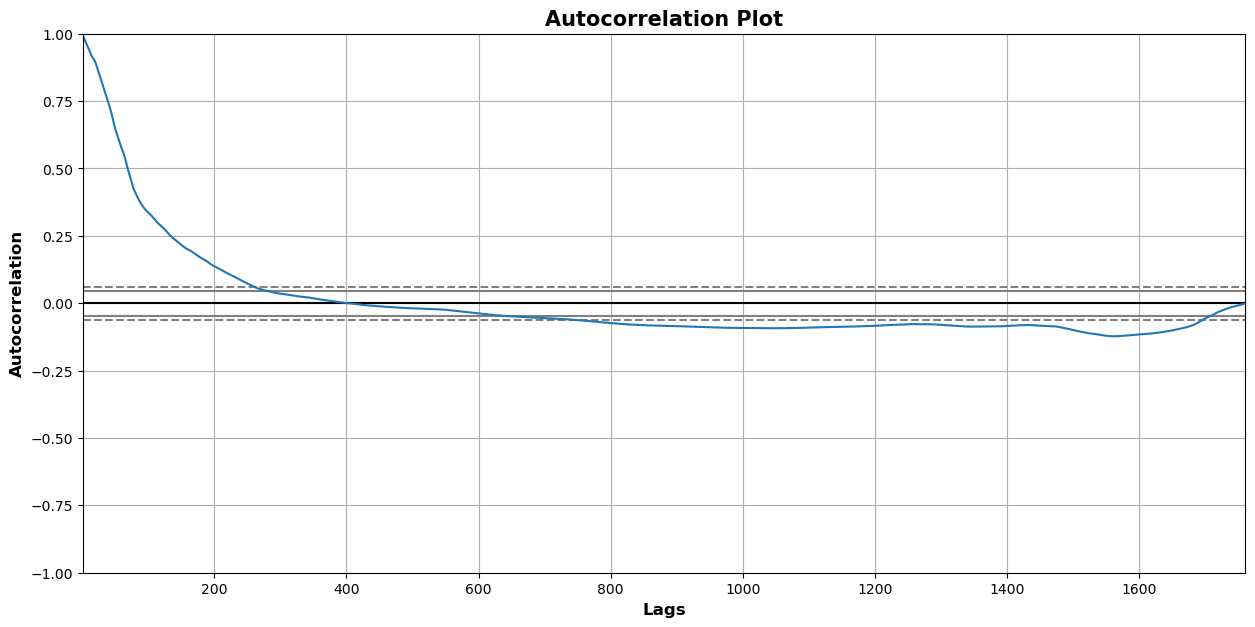

In [14]:
pd.plotting.autocorrelation_plot(btc['close'])
plt.xlabel('Lags', fontsize=12, fontweight='bold')
plt.ylabel('Autocorrelation', fontsize=12, fontweight='bold')
plt.title('Autocorrelation Plot', fontsize=15, fontweight='bold')
plt.show()

Lambda: -0.307180


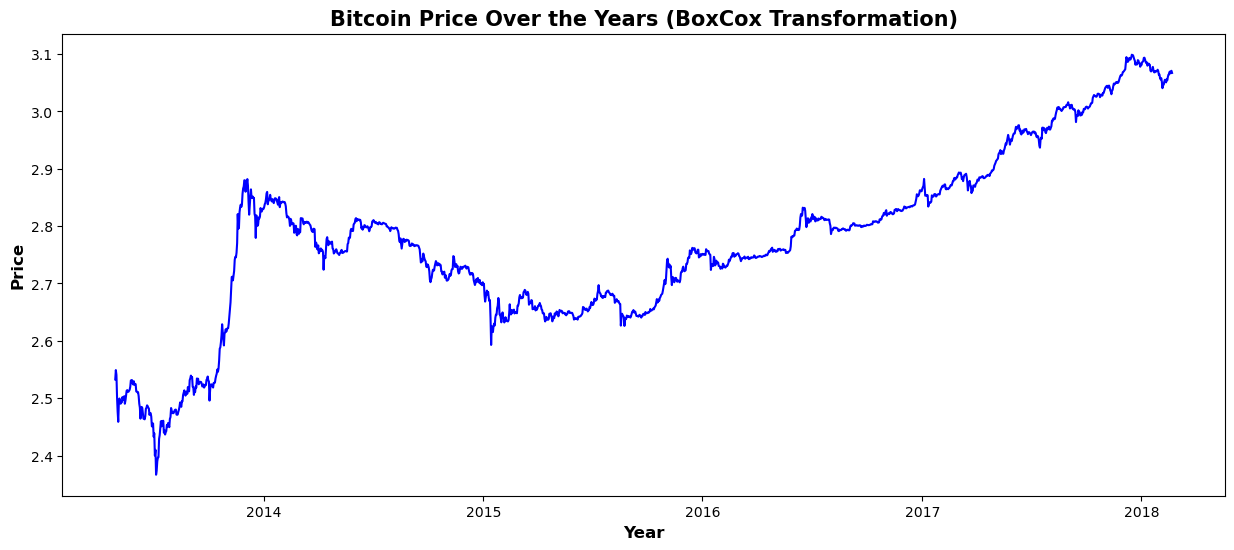

In [23]:
# removing seasonality with boxcox transformation
btc['close_boxcox'], lam = stats.boxcox(btc['close'])

print('Lambda: %f' % lam)
plt.figure(figsize=(15,6))
plt.plot(btc['close_boxcox'], color='blue')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.title('Bitcoin Price Over the Years (BoxCox Transformation)', fontsize=15, fontweight='bold')
plt.show()

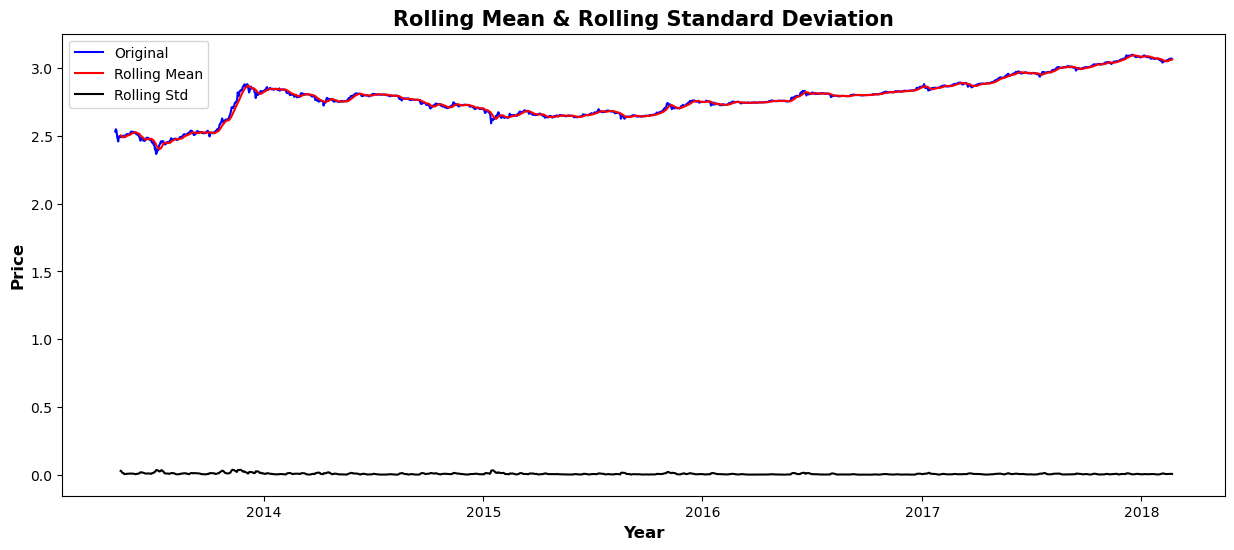

In [24]:
# plotting rolling average and rolling standard deviation
window_size = 10
rolling_mean = btc['close_boxcox'].rolling(window=window_size).mean()
rolling_std = btc['close_boxcox'].rolling(window=window_size).std()

plt.figure(figsize=(15,6))
plt.plot(btc['close_boxcox'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

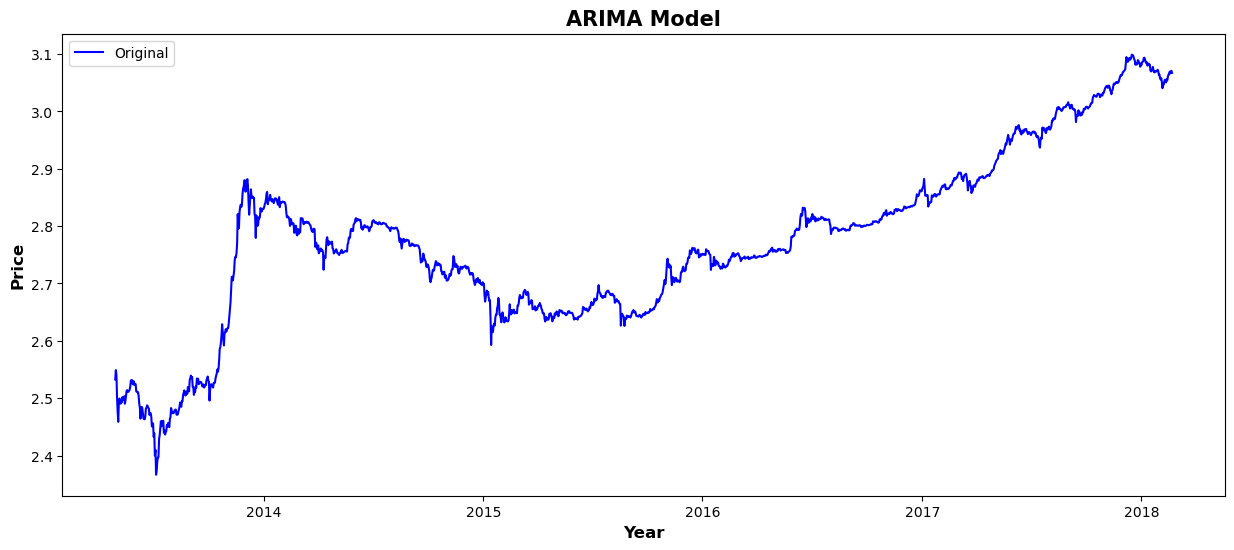

In [22]:
# fitting an arima model
model = ARIMA(btc['close_boxcox'], order=(1, 1, 1))
results = model.fit()
plt.figure(figsize=(15,6))
plt.plot(btc['close_boxcox'], color='blue', label='Original')
#plt.plot(results.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA Model', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()